# Airbnb Classification Models

#### Import the packages that will be used for this analysis

In [120]:
#import packages

#manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
#Processing and scoring
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.utils import class_weight

#Models to test
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.neighbors import KNeighborsClassifier


from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (16,8)

In [121]:
#set pandas options
pd.set_option('display.max_rows', 40)
pd.options.display.float_format = '{:.2f}'.format

## Setup and Modeling

In [122]:
#Read in raw data file
df = pd.read_csv('airbnb_less_1000.csv', low_memory=False, converters={'amenities':literal_eval})
bins = [1, 200, 400, 1000]
labels = ['Budget', 'Mid-price', 'Premium']
df['Category'] = pd.cut(x=df.price, bins=bins, labels=labels)
df = df.drop('price', axis=1)

In [123]:
#New category counts
df.Category.value_counts()

Budget       29102
Mid-price     7543
Premium       2734
Name: Category, dtype: int64

In [201]:
df.shape

(39379, 2)

In [124]:
#get most frequently mentioned amenities
mlb = MultiLabelBinarizer()
top_amenities = pd.DataFrame(mlb.fit_transform(df.amenities), \
                columns=mlb.classes_, index=df.index).apply(pd.value_counts).T \
                .sort_values(1, ascending=False).head(100)
top_amenities

,0,1
Wifi,2832,36547
Long term stays allowed,3820,35559
Smoke alarm,3987,35392
Kitchen,4370,35009
Essentials,5866,33513
...,...,...
Crib,38129,1250
Paid parking garage off premises,38263,1116
High chair,38327,1052
Shared patio or balcony,38366,1013


In [125]:
#get list of top amenities to grab columns
amenity_columns = list(top_amenities.index)

In [126]:
#Create dataframe of columns of top n amenities
amenity_df = pd.DataFrame(mlb.fit_transform(df.amenities), \
                columns=mlb.classes_, index=df.index)

In [127]:
#Join amenities to original dataframe
df = df.join(amenity_df[amenity_columns])

In [128]:
#Validate join
df.Category.value_counts()

Budget       29102
Mid-price     7543
Premium       2734
Name: Category, dtype: int64

In [129]:
#Split data into training and testing sets

#Drop columns we don't need
df = df.drop(['neighbourhood_cleansed','neighbourhood_group_cleansed', 'host_is_superhost', 'has_availability', 'instant_bookable', 'amenities'], axis=1)

#This transforms our only categorical feature into dummy variables
transformer = make_column_transformer(
                (OneHotEncoder(sparse=False), ['room_type']),
                 remainder = 'passthrough')

#Select target
y = df['Category']

#Make column transformer for categorical variable
transformed = transformer.fit_transform(df.drop(['Category'], axis=1))
X = pd.DataFrame(transformed, columns = transformer.get_feature_names())

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123, stratify=y)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [130]:
#model tuning parameters used for XGBoost models
estimators = 500
max_depth = 7
learning_rate = 0.1

In [24]:
#KNN
knn = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=20)
knn.fit(X_train, y_train)
knn_train_pred = knn.predict(X_train)
print(metrics.classification_report(y_train, knn_train_pred))
print('----------------------------------------------------------------------')
knn_test_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, knn_test_pred))
KNN_test_cm = metrics.confusion_matrix(y_test, knn_test_pred)

              precision    recall  f1-score   support

      Budget       0.79      0.99      0.88     20371
   Mid-price       0.71      0.19      0.29      5280
     Premium       0.74      0.23      0.36      1914

    accuracy                           0.78     27565
   macro avg       0.75      0.47      0.51     27565
weighted avg       0.77      0.78      0.73     27565

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.79      0.99      0.87      8731
   Mid-price       0.62      0.17      0.27      2263
     Premium       0.69      0.22      0.33       820

    accuracy                           0.78     11814
   macro avg       0.70      0.46      0.49     11814
weighted avg       0.75      0.78      0.72     11814



In [25]:
#Set undersample/oversample variables for XGBoost model
undersample = RandomUnderSampler(sampling_strategy={'Budget':10000, 'Mid-price':5000, 'Premium':2000})
oversample = RandomOverSampler(sampling_strategy={'Budget':21000, 'Mid-price':20000, 'Premium':20000})

#Oversample
X_over, y_over = oversample.fit_resample(X_train, y_train)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (21000) in class Budget will be larger than the number of samples in the majority class (class #Budget -> 20371)
  warnings.warn(


In [26]:
#Oversampled XGBoost
xgb_model_over = XGBClassifier(learning_rate=learning_rate, n_estimators=estimators, max_depth=max_depth, random_state=123)
xgb_model_over.fit(X_over, y_over)
xgb_train_pred_over = xgb_model_over.predict(X_over)
print(metrics.classification_report(y_over, xgb_train_pred_over))
print('----------------------------------------------------------------------')
xgb_test_pred_over = xgb_model_over.predict(X_test)
print(metrics.classification_report(y_test, xgb_test_pred_over))
xgb_test_over_cm = metrics.confusion_matrix(y_test, xgb_test_pred_over)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Budget       1.00      0.99      0.99     21000
   Mid-price       0.99      1.00      0.99     20000
     Premium       1.00      1.00      1.00     20000

    accuracy                           1.00     61000
   macro avg       1.00      1.00      1.00     61000
weighted avg       1.00      1.00      1.00     61000

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.92      0.92      0.92      8731
   Mid-price       0.63      0.67      0.65      2263
     Premium       0.75 

In [27]:
#Regular data XGBoost
xgb_model_base = XGBClassifier(learning_rate=learning_rate, n_estimators=estimators, max_depth=max_depth, random_state=123)
xgb_model_base.fit(X_train, y_train)
xgb_train_pred = xgb_model_base.predict(X_train)
print(metrics.classification_report(y_train, xgb_train_pred))
print('----------------------------------------------------------------------')
xgb_test_pred = xgb_model_base.predict(X_test)
print(metrics.classification_report(y_test, xgb_test_pred))
xgb_test_cm = metrics.confusion_matrix(y_test, xgb_test_pred)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Budget       0.99      1.00      1.00     20371
   Mid-price       1.00      0.97      0.98      5280
     Premium       1.00      0.99      0.99      1914

    accuracy                           0.99     27565
   macro avg       1.00      0.99      0.99     27565
weighted avg       0.99      0.99      0.99     27565

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.90      0.96      0.93      8731
   Mid-price       0.68      0.60      0.64      2263
     Premium       0.80 

In [28]:
#Used for XGBoost with class weights
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [29]:
#Class weight XGBoost model
xgb_model_weight = XGBClassifier(learning_rate=learning_rate, n_estimators=estimators, max_depth=max_depth, random_state=123)
xgb_model_weight.fit(X_train, y_train, sample_weight=classes_weights)
xgb_train_pred_weight = xgb_model_weight.predict(X_train)
print(metrics.classification_report(y_train, xgb_train_pred))
print('----------------------------------------------------------------------')
xgb_test_pred_weight = xgb_model_weight.predict(X_test)
print(metrics.classification_report(y_test, xgb_test_pred))
xgb_test_weight_cm = metrics.confusion_matrix(y_test, xgb_test_pred_weight)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Budget       0.99      1.00      1.00     20371
   Mid-price       1.00      0.97      0.98      5280
     Premium       1.00      0.99      0.99      1914

    accuracy                           0.99     27565
   macro avg       1.00      0.99      0.99     27565
weighted avg       0.99      0.99      0.99     27565

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.90      0.96      0.93      8731
   Mid-price       0.68      0.60      0.64      2263
     Premium       0.80 

In [30]:
#Random Forest Model
rf_model = RandomForestClassifier(n_estimators = 500, max_depth=10, min_samples_split=2, random_state=123)
rf_model.fit(X_train, y_train)
rf_train_pred = rf_model.predict(X_train)
print(metrics.classification_report(y_train, rf_train_pred))
print('----------------------------------------------------------------------')
rf_test_pred = rf_model.predict(X_test)
print(metrics.classification_report(y_test, rf_test_pred))
rf_model_cm = metrics.confusion_matrix(y_test, rf_test_pred)

              precision    recall  f1-score   support

      Budget       0.85      0.99      0.92     20371
   Mid-price       0.78      0.44      0.56      5280
     Premium       0.97      0.39      0.55      1914

    accuracy                           0.85     27565
   macro avg       0.87      0.61      0.68     27565
weighted avg       0.84      0.85      0.82     27565

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.83      0.99      0.90      8731
   Mid-price       0.64      0.34      0.45      2263
     Premium       0.91      0.27      0.42       820

    accuracy                           0.81     11814
   macro avg       0.79      0.53      0.59     11814
weighted avg       0.80      0.81      0.78     11814



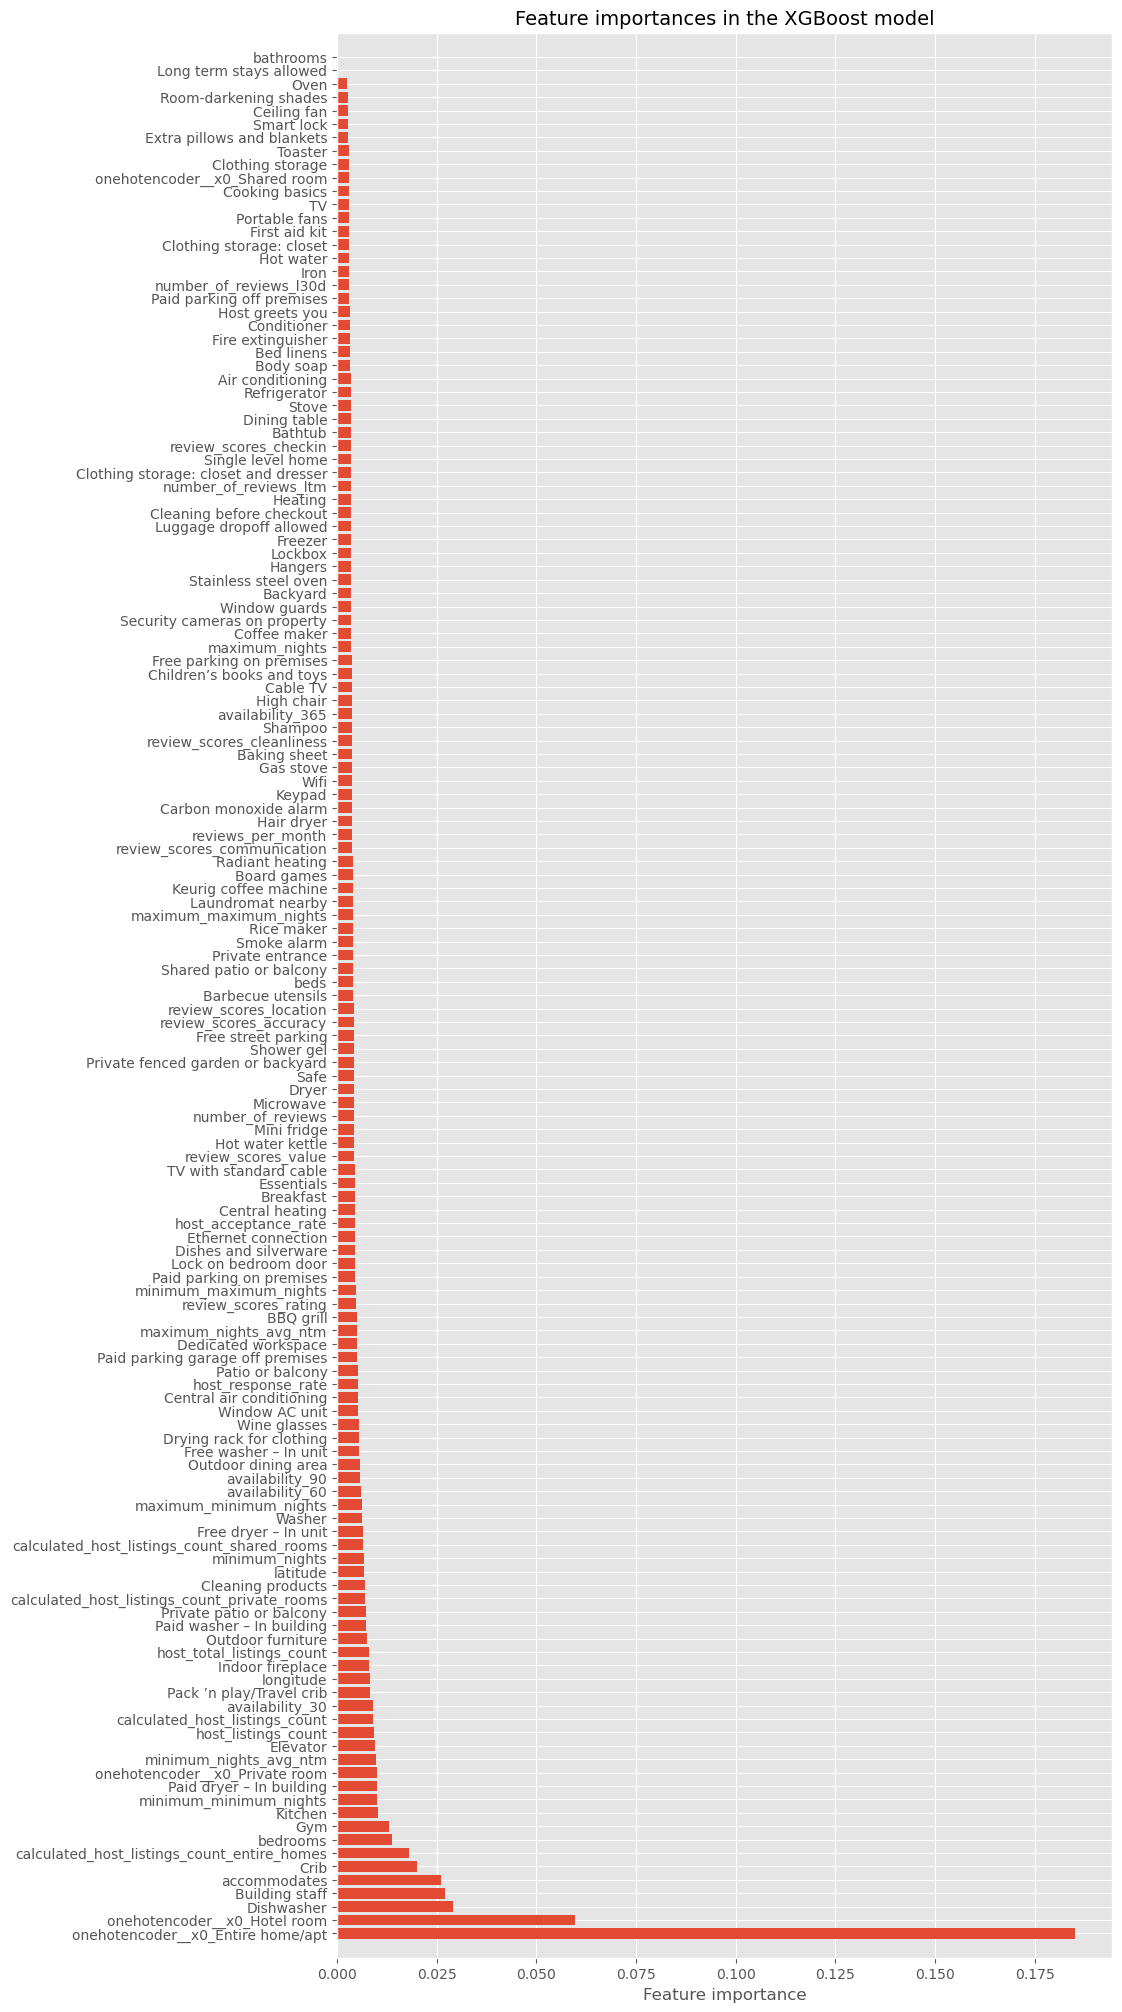

In [32]:
feat_wgts_xgb_model = pd.DataFrame(xgb_model_base.feature_importances_, columns=['weight'], index=X_train.columns)
feat_wgts_xgb_model.sort_values('weight', ascending=False, inplace=True)
#feat_wgts_xgb_model.sort_values(by='weight')

plt.figure(figsize=(10,25))
plt.barh(feat_wgts_xgb_model.index, feat_wgts_xgb_model['weight'], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [33]:
feat_wgts_xgb_model.sort_values(by='weight', ascending=False).head(10)

,weight
onehotencoder__x0_Entire home/apt,0.19
onehotencoder__x0_Hotel room,0.06
Dishwasher,0.03
Building staff,0.03
accommodates,0.03
Crib,0.02
calculated_host_listings_count_entire_homes,0.02
bedrooms,0.01
Gym,0.01
Kitchen,0.01


In [132]:
#Downselect dataframe to only latitude and longitude
#df = df[['longitude', 'latitude', 'availability_365', 'reviews_per_month', 'accommodates', 'availability_30', 'review_scores_location']]
df = df[['longitude', 'latitude']]
#Recreate training/testing data with reduced features
X = df

#split data
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X, y, test_size = 0.3, random_state = 123)

#size of training set
X_train.shape

(27565, 141)

In [133]:
#Latitude Longitude XGBoost
xgb_model_lat = XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=7, random_state=123)
xgb_model_lat.fit(X_train_lat, y_train_lat)
xgb_train_pred_lat = xgb_model_lat.predict(X_train_lat)
xgb_test_pred_lat = xgb_model_lat.predict(X_test_lat)

print(metrics.classification_report(y_train, xgb_train_pred_lat))
print('----------------------------------------------------------------------')
print(metrics.classification_report(y_test_lat, xgb_test_pred_lat))
xgb_lat_cm = metrics.confusion_matrix(y_test_lat, xgb_test_pred_lat)

/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:16:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Budget       0.74      0.90      0.81     20371
   Mid-price       0.19      0.08      0.11      5280
     Premium       0.07      0.03      0.04      1914

    accuracy                           0.68     27565
   macro avg       0.33      0.33      0.32     27565
weighted avg       0.59      0.68      0.62     27565

----------------------------------------------------------------------
              precision    recall  f1-score   support

      Budget       0.78      0.96      0.86      8674
   Mid-price       0.45      0.17      0.24      2283
     Premium       0.52 

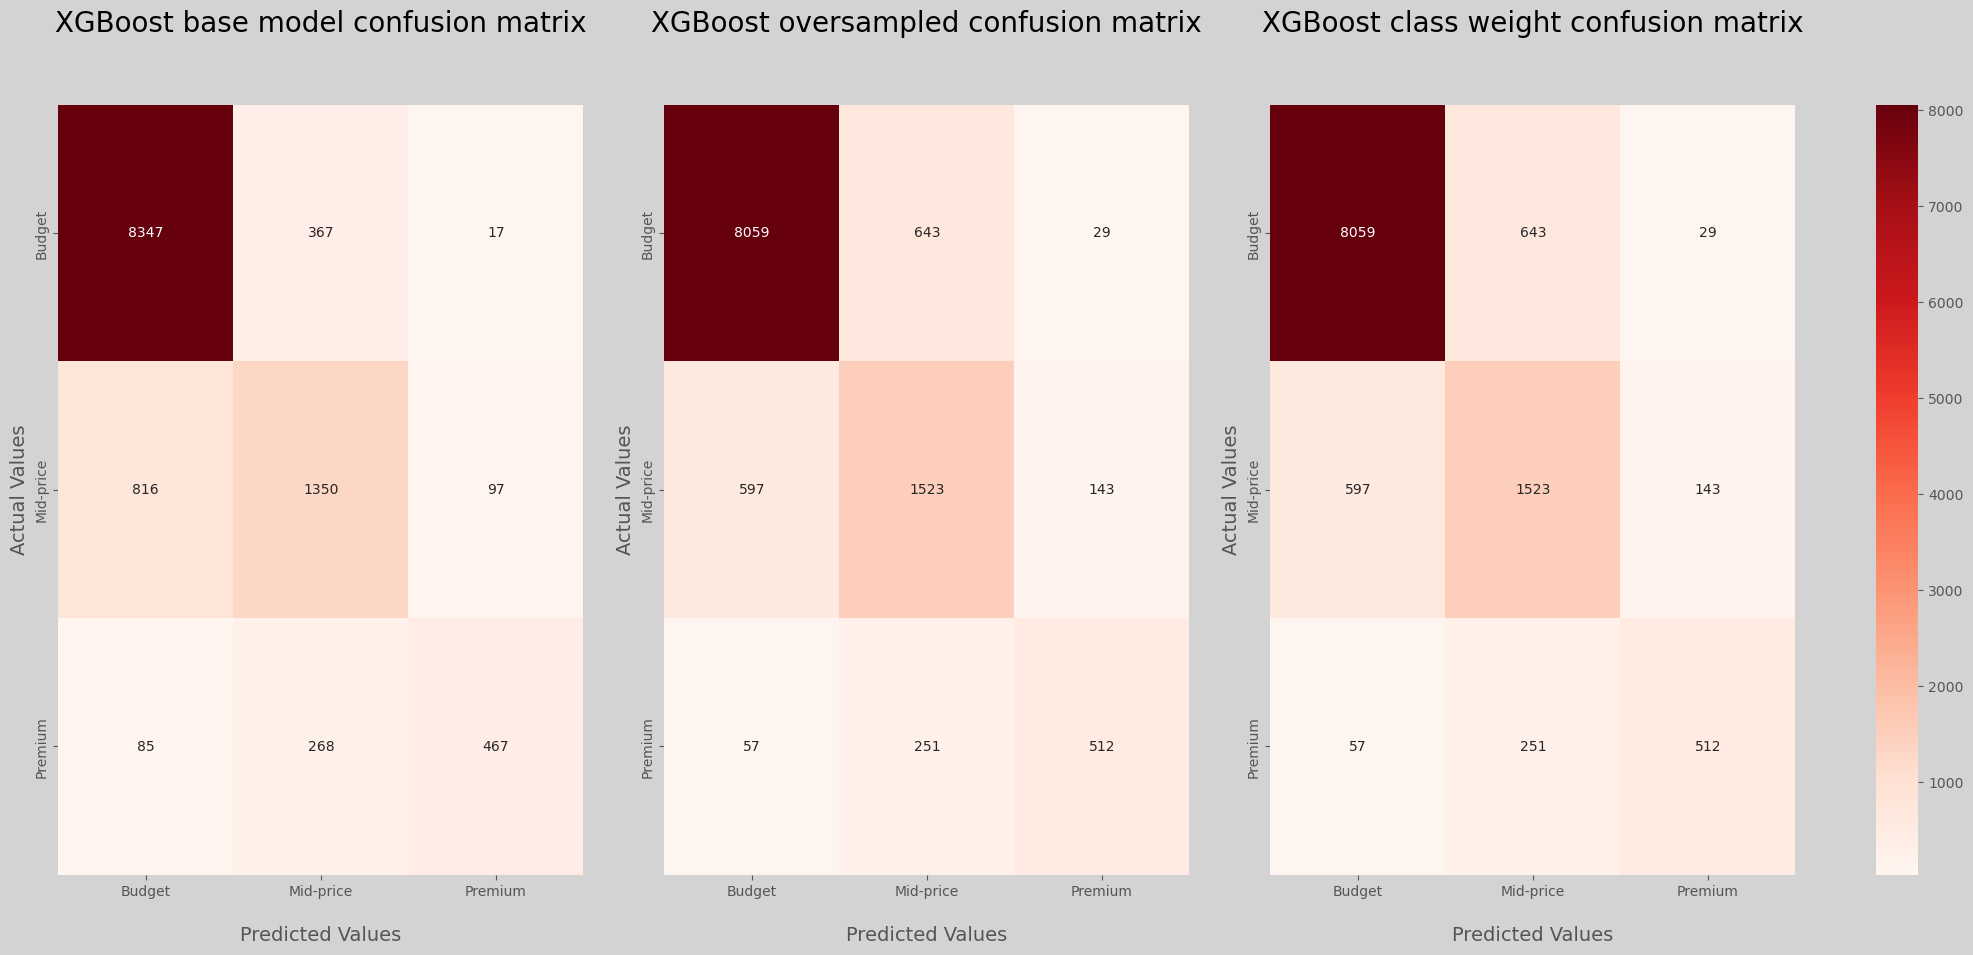

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,10), gridspec_kw={'width_ratios':[1,1,1,0.08]})
axs[0].get_shared_y_axes().join(axs[1], axs[2])
#rXGBoost base
xgb_base = sns.heatmap(xgb_test_cm, annot=True, cmap='Reds', cbar=False, ax=axs[0], fmt='d')
xgb_base.set_title('XGBoost base model confusion matrix\n\n', fontsize=20)
xgb_base.set_xlabel('\nPredicted Values', fontsize=14)
xgb_base.set_ylabel('Actual Values', fontsize=14)
xgb_base.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
xgb_base.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])

#XGBoost Over Sample
xgb_over = sns.heatmap(xgb_test_over_cm, annot=True, cmap='Reds', ax=axs[1], fmt='d', cbar_ax=axs[3])
xgb_over.set_title('XGBoost oversampled confusion matrix\n\n', fontsize=20)
xgb_over.set_xlabel('\nPredicted Values', fontsize=14)
xgb_over.set_ylabel('Actual Values', fontsize=14)
xgb_over.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
xgb_over.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])

#XGBoost Class Weights
xgb_class = sns.heatmap(xgb_test_over_cm, annot=True, cmap='Reds', ax=axs[2], cbar=False, fmt='d')
xgb_class.set_title('XGBoost class weight confusion matrix\n\n', fontsize=20)
xgb_class.set_xlabel('\nPredicted Values', fontsize=14)
xgb_class.set_ylabel('Actual Values', fontsize=14)
xgb_class.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
xgb_class.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
fig.patch.set_facecolor('lightgray')
plt.show()

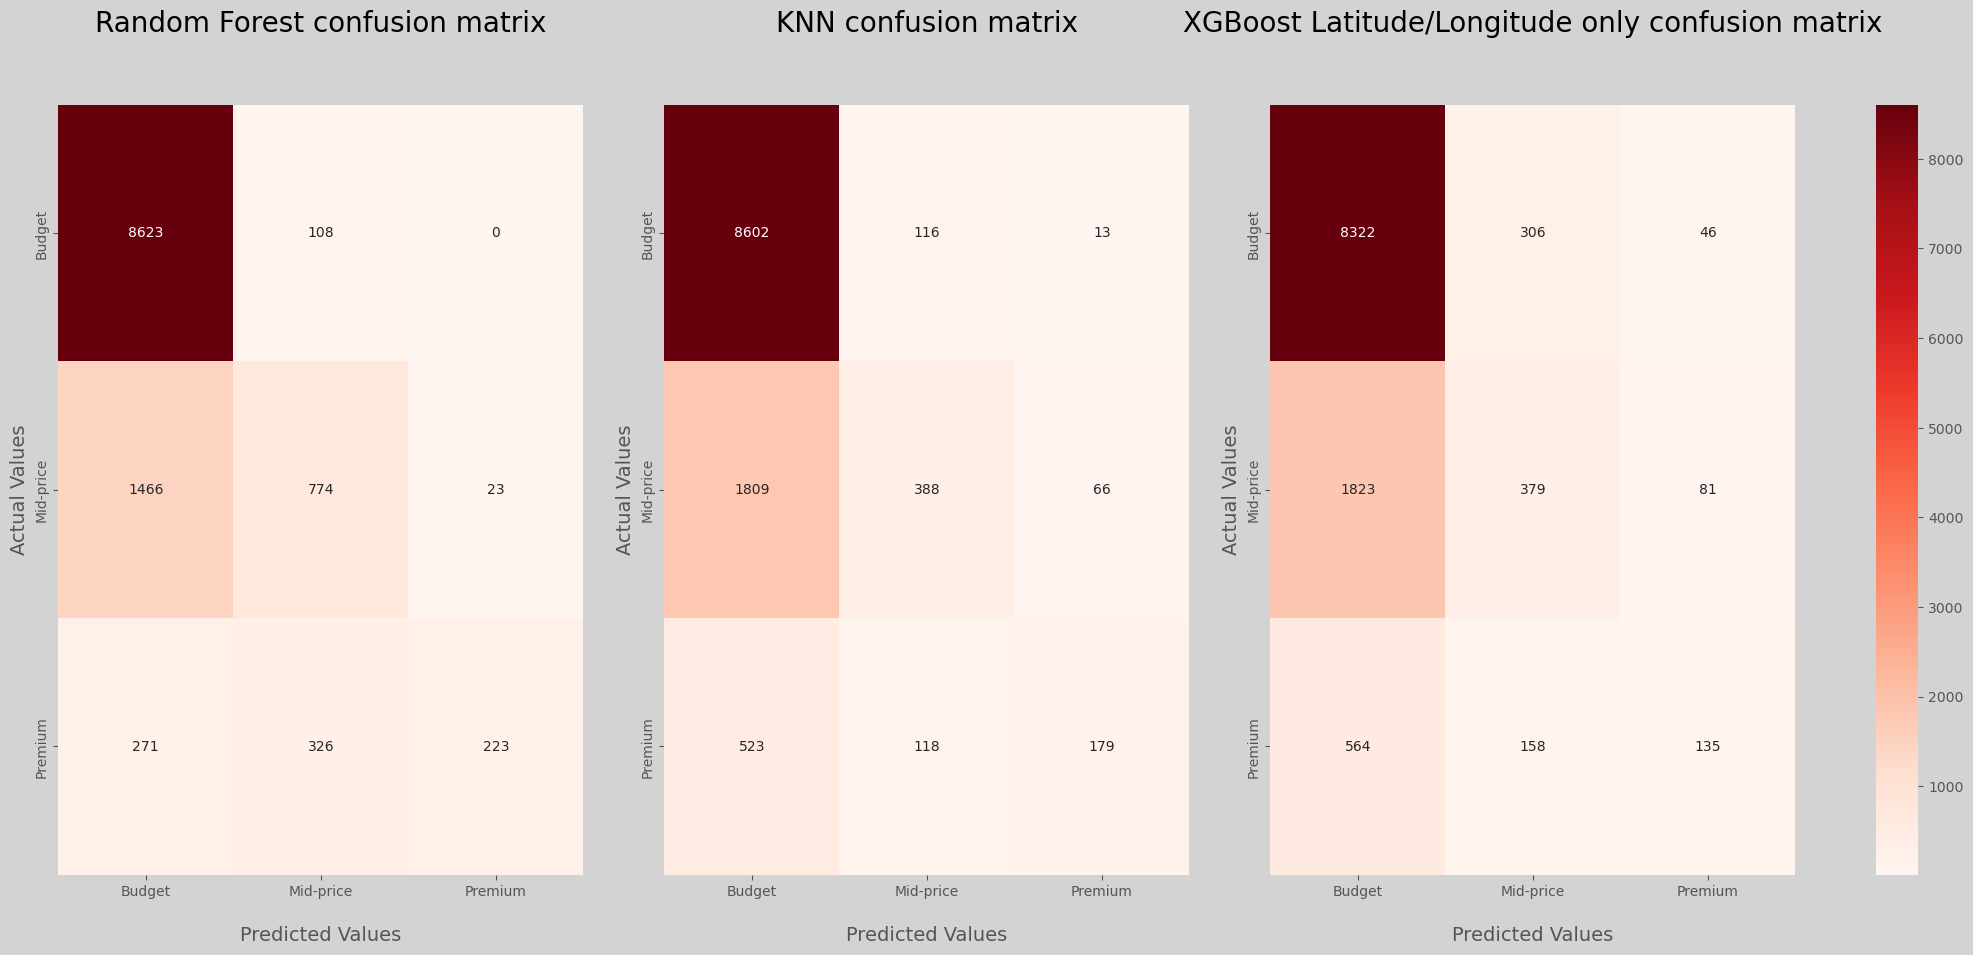

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,10), gridspec_kw={'width_ratios':[1,1,1,0.08]})
axs[0].get_shared_y_axes().join(axs[1], axs[2])
#Random Forest
rf = sns.heatmap(rf_model_cm, annot=True, cmap='Reds', cbar=False, ax=axs[0], fmt='d')
rf.set_title('Random Forest confusion matrix\n\n', fontsize=20)
rf.set_xlabel('\nPredicted Values', fontsize=14)
rf.set_ylabel('Actual Values', fontsize=14)
rf.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
rf.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])

#KNN
knn = sns.heatmap(KNN_test_cm, annot=True, cmap='Reds', ax=axs[1], fmt='d', cbar_ax=axs[3])
knn.set_title('KNN confusion matrix\n\n', fontsize=20)
knn.set_xlabel('\nPredicted Values', fontsize=14)
knn.set_ylabel('Actual Values', fontsize=14)
knn.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
knn.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])

#XGBoost Latitude Longitude
lat = sns.heatmap(xgb_lat_cm, annot=True, cmap='Reds', ax=axs[2], cbar=False, fmt='d')
lat.set_title('XGBoost Latitude/Longitude only confusion matrix\n\n', fontsize=20)
lat.set_xlabel('\nPredicted Values', fontsize=14)
lat.set_ylabel('Actual Values', fontsize=14)
lat.xaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
lat.yaxis.set_ticklabels(['Budget','Mid-price', 'Premium'])
fig.patch.set_facecolor('lightgray')
plt.show()

In [144]:
latitude = metrics.classification_report(y_test_lat, xgb_test_pred_lat, output_dict=True)
knn = metrics.classification_report(y_test, knn_test_pred, output_dict=True)
xgb_base_ = metrics.classification_report(y_test, xgb_test_pred, output_dict=True)
xgb_over_ = metrics.classification_report(y_test, xgb_test_pred_over, output_dict=True)
rf_ = metrics.classification_report(y_test, rf_test_pred, output_dict=True)
xgb_class_ = metrics.classification_report(y_test, xgb_test_pred_weight, output_dict=True)

results = pd.concat([pd.DataFrame(xgb_base_).T, \
pd.DataFrame(xgb_over_).T, \
pd.DataFrame(xgb_class_).T, \
pd.DataFrame(latitude).T, \
pd.DataFrame(knn).T, \
pd.DataFrame(rf_).T \
], axis=0, keys=['XGB Base', 'XGB Oversample', 'XGB Class Weight', 'XGB_lat', 'KNN', 'RF']). \
unstack(level=0)[['precision', 'recall', 'f1-score']].T

results


Budget  Mid-price  Premium  accuracy  macro avg  \
precision XGB Base            0.90       0.68     0.80      0.86       0.80   
          XGB Oversample      0.92       0.63     0.75      0.85       0.77   
          XGB Class Weight    0.93       0.62     0.77      0.85       0.77   
          XGB_lat             0.78       0.45     0.52      0.75       0.58   
          KNN                 0.79       0.62     0.69      0.78       0.70   
          RF                  0.83       0.64     0.91      0.81       0.79   
recall    XGB Base            0.96       0.60     0.57      0.86       0.71   
          XGB Oversample      0.92       0.67     0.62      0.85       0.74   
          XGB Class Weight    0.91       0.70     0.63      0.85       0.75   
          XGB_lat             0.96       0.17     0.16      0.75       0.43   
          KNN                 0.99       0.17     0.22      0.78       0.46   
          RF                  0.99       0.34     0.27      0.81       0.53   
f1-score  XGB Base            0.93       0.64     0.67      0.86       0.74   
          XGB Oversample      0.92       0.65     0.68      0.85       0.75   
          XGB Class Weight    0.92       0.66     0.69      0.85       0.76   
          XGB_lat             0.86       0.24     0.24      0.75       0.45   
          KNN                 0.87       0.27     0.33      0.78       0.49   
          RF                  0.90       0.45     0.42      0.81       0.59   

                            weighted avg  
precision XGB Base                  0.85  
          XGB Oversample            0.86  
          XGB Class Weight          0.86  
          XGB_lat                   0.69  
          KNN                       0.75  
          RF                        0.80  
recall    XGB Base                  0.86  
          XGB Oversample            0.85  
          XGB Class Weight          0.85  
          XGB_lat                   0.75  
          KNN                       0.78  
          RF                        0.81  
f1-score  XGB Base                  0.85  
          XGB Oversample            0.85  
          XGB Class Weight          0.85  
          XGB_lat                   0.69  
          KNN                       0.72  
          RF                        0.78

In [197]:
accuracies = pd.DataFrame([xgb_base_['accuracy'], xgb_over_['accuracy'], xgb_class_['accuracy'],latitude['accuracy'], knn['accuracy'], rf_['accuracy']], index=['XGB Base', 'XGB Oversample', 'XGB Class Weight', 'XGB_lat', 'KNN', 'RF'])
accuracies = accuracies.rename(columns={0:'Accuracy'})
accuracies = accuracies.round(decimals=2)

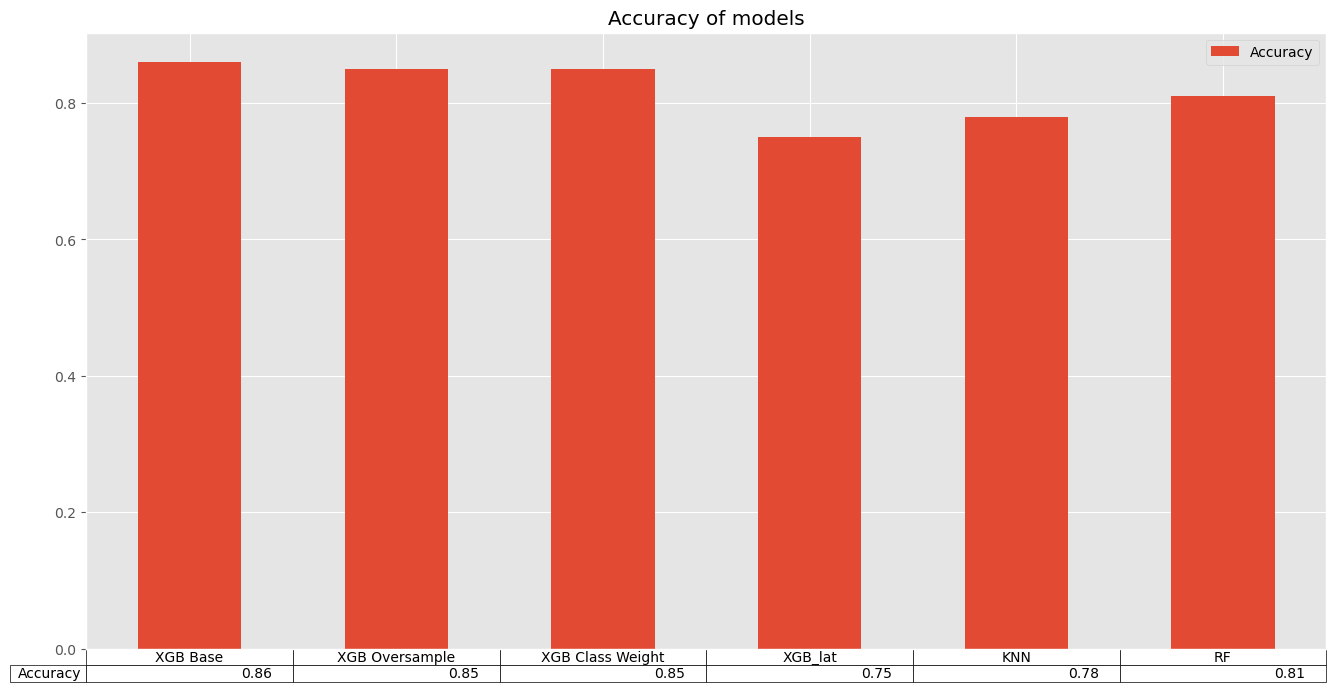

In [200]:
accuracies.plot(kind='bar', table=True)
plt.title('Accuracy of models')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()